In [19]:
import pandas as pd
from prophet import Prophet

In [20]:

# Python
df = pd.read_csv('covid_pa_confirmed_data_7d.csv')
df['ds'] = pd.to_datetime(df['time_value'])
df['y'] = df['value']
df = df[['ds', 'y']]

df.head()
# df.index = pd.to_datetime(df['time_value'])
# df = df[['value']]
# df['ds'] = df.index
# df['y'] = df['value']
# df = df[['ds', 'y']]
# df.index = df['ds']
# df = df.drop(['ds'], axis=1)
# df.head()

,ds,y
0,2020-02-20,0.0
1,2020-02-21,0.0
2,2020-02-22,0.0
3,2020-02-23,0.0
4,2020-02-24,0.0


In [30]:
data = pd.read_csv("../src/chimeric_tools/data/weekly_covid.csv.gz", compression="gzip")
data["location"] = data["location"].astype(str)
data = data.groupby("location_name")
data1 = pd.DataFrame()
for idx,sub in data:
    data1 = sub
    break
data1
# df['ds'] = pd.to_datetime(data1['date'])
# df['y'] = data1['value']
# df



/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3427: DtypeWarning:

Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.



,location,location_name,date,end_date,EW,value,pred,residual
273431,45001,Abbeville County,2020-01-19,2020-01-25,202004,0,0.000000,0.000000
273432,45001,Abbeville County,2020-01-26,2020-02-01,202005,0,0.000000,0.000000
273433,45001,Abbeville County,2020-02-02,2020-02-08,202006,0,0.000000,0.000000
273434,45001,Abbeville County,2020-02-09,2020-02-15,202007,0,0.000000,0.000000
273435,45001,Abbeville County,2020-02-16,2020-02-22,202008,0,0.000000,0.000000
...,...,...,...,...,...,...,...,...
273553,45001,Abbeville County,2022-05-22,2022-05-28,202221,25,7.821040,17.178960
273554,45001,Abbeville County,2022-05-29,2022-06-04,202222,9,28.739953,-19.739953
273555,45001,Abbeville County,2022-06-05,2022-06-11,202223,8,5.790411,2.209589
273556,45001,Abbeville County,2022-06-12,2022-06-18,202224,25,7.708185,17.291815


In [31]:
df = pd.DataFrame(data1)
df['ds'] = pd.to_datetime(df['date'])
df['y'] = df['value']
df = df[['ds', 'y']]
df

,ds,y
273431,2020-01-19,0
273432,2020-01-26,0
273433,2020-02-02,0
273434,2020-02-09,0
273435,2020-02-16,0
...,...,...
273553,2022-05-22,25
273554,2022-05-29,9
273555,2022-06-05,8
273556,2022-06-12,25


In [32]:
class Prophet_model:
    from prophet import Prophet
    def __init__(self, data : pd.DataFrame,load_model=False):
        self.data = data
        if load_model:
            self.model = Prophet.load('prophet_model.pkl')
        else:
            self.model = None
            self.best_params = self.get_best_params()
        
    def get_best_params(self):
        import itertools
        import numpy as np
        import pandas as pd
        from prophet.diagnostics import cross_validation
        from prophet.diagnostics import performance_metrics

        param_grid = {  
            'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
            'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
            'holidays_prior_scale': [0.01, 0.1, 1.0, 10.0],
                }
        # three cutoffs six months apart
        cutoffs = pd.to_datetime(['2020-08-15','2021-02-15', '2021-08-15', '2022-02-15'])
        # Generate all combinations of parameters
        all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
        rmses = []  # Store the RMSEs for each params here

        # Use cross validation to evaluate all parameters
        for params in all_params:
            m = Prophet(**params)  # Fit model with given params
            m.add_country_holidays(country_name='US')
            m = m.fit(df)
            df_cv = cross_validation(m, cutoffs=cutoffs, horizon='30 days', parallel="processes")
            # rolling_window specifies the proportion of forecasts to use in each rolling window
            df_p = performance_metrics(df_cv, rolling_window=1)
            rmses.append(df_p['rmse'].values[0])
        best_params = all_params[np.argmin(rmses)]
        return best_params
    def fit(self):
        best_params = self.get_best_params()
        # params = {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10}
        self.model = Prophet(**best_params)
        self.model.add_country_holidays(country_name='US')      
        self.model.fit(self.data)
        # save the model
        self.model.save('prophet_model.pkl')
    def predict(self,periods):
        from prophet.plot import plot_plotly, plot_components_plotly
        future = self.model.make_future_dataframe(periods=periods, freq='W')
        forecast = self.model.predict(future)
        return plot_plotly(self.model, forecast)
    def get_residuals(self):
        return self.model.residual_df
        
model = Prophet_model(df)
model.fit()
model.predict(periods=4)
    

INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
ERROR:cmdstanpy:Chain [1] error: error during processing Stale NFS file handle
Optimization terminated abnormally. Falling back to Newton.
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
ERROR:cmdstanpy:Chain [1] error: error during processing Stale NFS file handle
Optimization terminated abnormally. Falling back to Newton.
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start proces

AttributeError: 'Prophet' object has no attribute 'save'

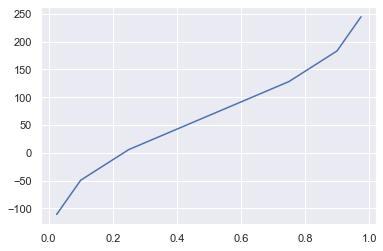

array([  0.        ,   0.        ,   5.756136  ,  67.        ,
       128.243864  , 183.36525206, 244.96529552])

In [59]:
import numpy as np
train_Data = np.array(df['y']).astype(int)
# set the negative values to zero
def set_negative_to_zero(data):
    data[data<0] = 0
    return data
train_Data = set_negative_to_zero(train_Data)
# cal the parameters of normal distribution miu and sigma
def get_normal_params(data):
    import numpy as np
    import pandas as pd
    import scipy.stats as stats
    future = model.model.make_future_dataframe(periods=1, freq='W')
    forecast = model.model.predict(future)
    miu = forecast.tail(1)['yhat'].astype(int)
    # cal sigma
    sigma = np.std(data)
        
    return miu,sigma
miu,sigma = get_normal_params(train_Data)
# plot the normal distribution with miu and sigma
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
sns.set()
# plot the normal distribution with miu and sigma
def plot_normal_distribution(miu,sigma):
    qutial = [0.025,0.100,0.250,0.500,0.750,0.900,0.975]
    ppf_list = norm.ppf(qutial,miu,sigma)
    plt.plot(qutial,ppf_list)
    plt.show()
    return ppf_list
quntail_Value = plot_normal_distribution(miu,sigma)
quntail_Value[quntail_Value<0] = 0
quntail_Value


In [ ]:
        future = self.model.make_future_dataframe(periods=periods, freq='W')
        forecast = self.model.predict(future)

In [60]:
model.model.history['y']

0       0
1       0
2       0
3       0
4       0
       ..
122    25
123     9
124     8
125    25
126    32
Name: y, Length: 127, dtype: int64

In [61]:
train_Data

array([  0,   0,   0,   0,   0,   0,   0,   0,   1,   2,   3,   3,   6,
         9,   7,   3,   0,   1,   4,   8,  16,  23,  17,  16,  31,  35,
        79,  24,  37,  35,  25,  21,  56,  26,  42,  48,  55,  54,  20,
        32,  62,  35,  28,  42,  54,  72,  70,  61,  65,  54,  78, 112,
       210, 148, 142, 125,  77,  50,  56,  47,  32,  58,  30,  54,  22,
        15,  21,  11,   9,   7,  10,   3,   0,   0,   1,   0,   0,   0,
        16,  31,  37,  49,  78, 109, 150, 140, 218,  93, 104,  76,  65,
        53,  14,  23,  29,  23,  33,  38,  55,  72,  53, 125, 251, 471,
       699, 401, 263,  94,  92,  52,   9,   5,   1,   1,   8,   8,   5,
         2,   4,   4,   3,   7,  25,   9,   8,  25,  32])

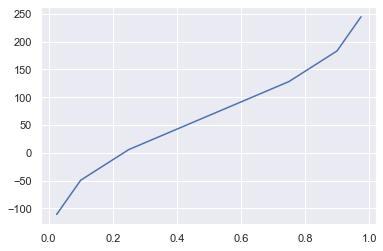

array([  0.        ,   0.        ,   5.756136  ,  67.        ,
       128.243864  , 183.36525206, 244.96529552])

In [47]:
model.predict(periods=0)

In [ ]:
# m = Prophet()
# m.fit(df)
# 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01
m = Prophet(changepoint_prior_scale = 0.5, seasonality_prior_scale = 0.1, holidays_prior_scale = 0.01)
m.add_country_holidays(country_name='US')
m.fit(df)

INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
# Python
import itertools
import numpy as np
import pandas as pd
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'holidays_prior_scale': [0.01, 0.1, 1.0, 10.0],

}
# three cutoffs six months apart
cutoffs = pd.to_datetime(['2020-08-15','2021-02-15', '2021-08-15', '2022-02-15'])
# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params)  # Fit model with given params
    m.add_country_holidays(country_name='US')
    m = m.fit(df)
    df_cv = cross_validation(m, cutoffs=cutoffs, horizon='30 days', parallel="processes")
    # rolling_window specifies the proportion of forecasts to use in each rolling window
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
ERROR:cmdstanpy:Chain [1] error: error during processing Stale NFS file handle
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
Optimization terminated abnormally. Falling back to Newton.
ERROR:cmdstanpy:Chain [1] error: error during processing Stale NFS file handle
ERROR:cmdstanpy:Chain [1] error: error during processing Stale NFS file handle
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain 

    changepoint_prior_scale  seasonality_prior_scale  holidays_prior_scale  \
0                     0.001                     0.01                  0.01   
1                     0.001                     0.01                  0.10   
2                     0.001                     0.01                  1.00   
3                     0.001                     0.01                 10.00   
4                     0.001                     0.10                  0.01   
..                      ...                      ...                   ...   
59                    0.500                     1.00                 10.00   
60                    0.500                    10.00                  0.01   
61                    0.500                    10.00                  0.10   
62                    0.500                    10.00                  1.00   
63                    0.500                    10.00                 10.00   

           rmse  
0   2739.626509  
1   2780.122625  
2   2792.

/usr/local/lib/python3.7/site-packages/prophet/plot.py:544: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])
/usr/local/lib/python3.7/site-packages/prophet/plot.py:545: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])


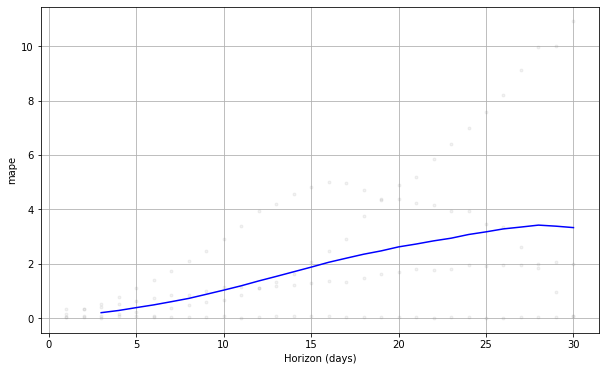

In [ ]:
from prophet.plot import plot_cross_validation_metric

fig = plot_cross_validation_metric(df_cv, metric='mape')


In [ ]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0}


INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
ERROR:cmdstanpy:Chain [1] error: error during processing Stale NFS file handle
Optimization terminated abnormally. Falling back to Newton.
INFO:cmdstanpy:Chain [1] done processing
ERROR:cmdstanpy:Chain [1] error: error during processing Stale NFS file handle
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
Optimization terminated abnormally. Falling back to Newton.
ERROR:cmdstanpy:Chain [1] error: error during processing Stale NFS file handle
INFO:cmdstanpy:Chain [1] start processing
Optimization terminated abnormally. Falling back to Newton.
INFO:cmdstanpy:Chain 

2656.681216753088


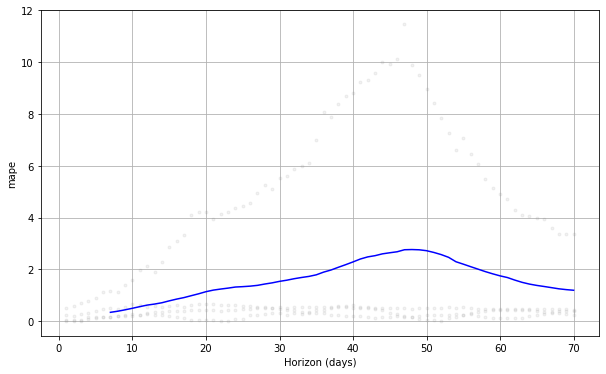

In [31]:
m = Prophet(**best_params)
m.add_country_holidays(country_name='US')
m = m.fit(df)

df_cv = cross_validation(m, cutoffs=cutoffs, horizon='70 days', parallel="processes")
fig = plot_cross_validation_metric(df_cv, metric='mape')

df_p = performance_metrics(df_cv, rolling_window=1)
print(df_p['rmse'].values[0])
future = m.make_future_dataframe(periods=14, freq='D')
forecast = m.predict(future)
plot_plotly(m, forecast)



/usr/local/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



Text(0.5, 1.0, 'Residuals distribution')

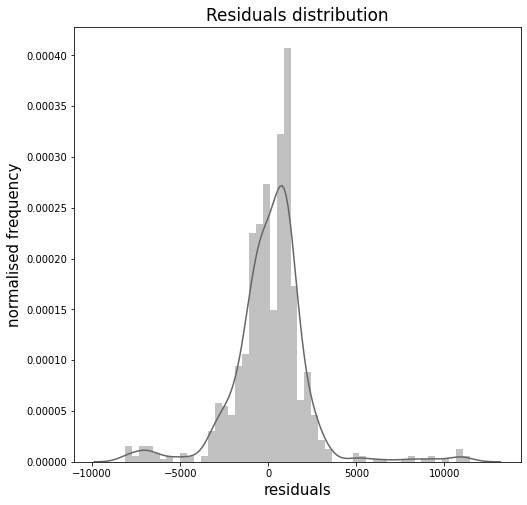

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt
future = m.make_future_dataframe(periods=0, freq='D')
history = m.history['y']
# draw the residuals
res = (history - forecast['yhat'])
f, ax = plt.subplots(figsize=(8,8))
sns.distplot(res, ax=ax, color='0.4')
ax.grid(ls=':')
ax.set_xlabel('residuals', fontsize=15)
ax.set_ylabel("normalised frequency", fontsize=15)
ax.grid(ls=':')
ax.set_title('Residuals distribution', fontsize=17)




In [1]:
# get the the percentage of residuals in [-1000, 1000]
res_in_range = [i for i in res if i > -500 and i < 500]
print(len(res_in_range)/len(res))


NameError: name 'res' is not defined